<h2>Simulating Lensed Quasar Light Curves with Microlensing

In this notebook, we will use one microlesning map, and and simulate lensed quasar curves in multiple bands. 

In [1]:
from amoeba.Classes.accretion_disk import AccretionDisk
from amoeba.Classes.magnification_map import MagnificationMap
import amoeba.Util.util as util
import numpy as np
import numpy.random as random
from astropy.io import fits
import astropy.constants as ac
import astropy.units as au
from astropy.nddata import block_reduce
from scipy import signal
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
import sys
import time as supertime

example_disk_path = "../SampleDisks/RayTrace.fits"
example_mag_map_path = "/Users/padmavenkatraman/Documents/StrongLensing/AM/mapA.fits"  # Insert a path to a magnification map (download seperate)

In [2]:
util

<module 'amoeba.Util.util' from '/Users/padmavenkatraman/Documents/StrongLensing/AM/amoeba_ver2/Amoeba/amoeba/src/amoeba/Util/util.py'>

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


### Microlensing map

In this section we look at the microlensing map, make a histogram of the values and look at the magnification of the images.

In [4]:
example_mag_map_path = "/Users/padmavenkatraman/Documents/StrongLensing/AM/mapA.fits"  # Insert a path to a magnification map (download seperate)

8192


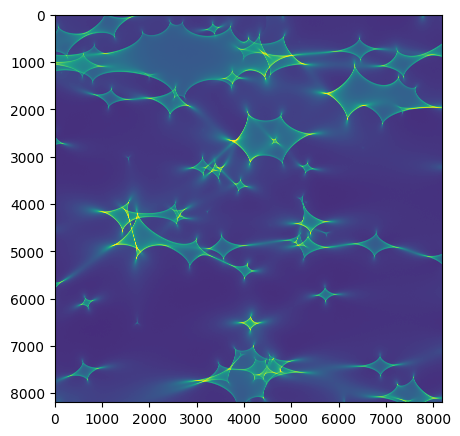

In [5]:
from astropy.visualization import simple_norm
fig, ax =plt.subplots(figsize=(5,6))
hdul = fits.open(example_mag_map_path)
hdul0 = hdul[0]
mag_map_num_pix = hdul0.shape[0]
star_mass = 0.3 # solar mass
zsrc = 1.29
zlens = 0.317
theta_e = 20 #number of einstein radii in map
norm = simple_norm(hdul0.data, stretch ='asinh', asinh_a=0.2, vmin=0, vmax=20)
ax.imshow(hdul0.data, cmap='viridis', norm=norm)
print(mag_map_num_pix)

In [6]:
# make a magnification map object
MagMap = MagnificationMap(redshift_source = zsrc,
        redshift_lens=zlens,
        magnification_array=hdul0.data,
        convergence=0.3,
        shear=0.2,
        mean_microlens_mass_in_kg=star_mass * ac.M_sun.to(au.kg),
        total_microlens_einstein_radii=theta_e,
        OmM=0.3,
        H0=70)

einstein radius in m: 341566825103311.25
pixel_size:  833903381599.881


Text(0.5, 1.0, 'Macro $\\mu = \\frac{1}{(1-\\kappa)^2 - \\gamma^2} = 2.2; \\kappa = 0.3; \\gamma = 0.2$')

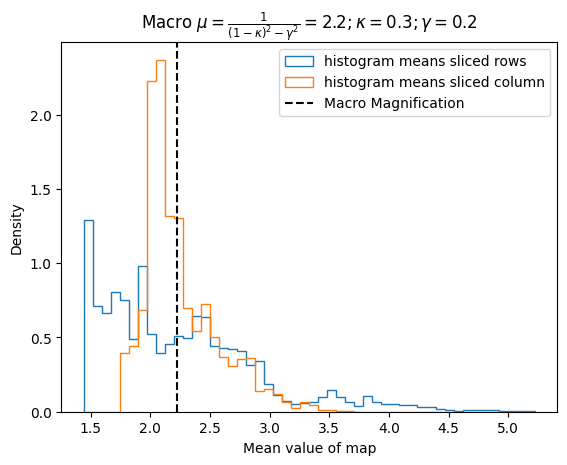

In [7]:
means_x = [np.mean(hdul0.data[i,:]) for i in range(8192)]
# fig, ax = plt.subplots(1,2,figsize=(10,5))
means_y = [np.mean(hdul0.data[:,i]) for i in range(8192)]
# ax[0].imshow(hdul0.data, cmap='viridis', norm=norm)
# ax[1].plot(means_x, means_y)
plt.figure()
_,bins,_=plt.hist(means_x, density=True,label='histogram means sliced rows', bins=50,histtype='step')
plt.hist(means_y, density=True,label='histogram means sliced column',bins=bins,histtype='step');
plt.xlabel("Mean value of map")
plt.ylabel("Density");
plt.axvline(MagMap.macro_magnification, ls='--', label='Macro Magnification', color='k')
plt.legend();
plt.title(r"Macro $\mu = \frac{1}{(1-\kappa)^2 - \gamma^2} = 2.2; \kappa = 0.3; \gamma = 0.2$")

### Pixel to arcsec relation in microlensing map and accretion disk source plane

In this section we compute the size of the disk in the source plane, so that the pixel size in the microlensing map (projected onto the source plane) and source plane is consistent.

The angular size of a pixel = physical size / distance

In [8]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70 * au.km / au.s / au.Mpc, Tcmb0=2.725 * au.K, Om0=0.3)
mag_map_ps_zlens = (((MagMap.pixel_size*au.m).to(au.Mpc)/cosmo.angular_diameter_distance(z=zlens))*au.radian).to(au.arcsec)
mag_map_ps_zsrc = (((MagMap.pixel_size*au.m).to(au.Mpc)/cosmo.angular_diameter_distance(z=zsrc))*au.radian).to(au.arcsec)
print(f"Microlensing map arcsec/pixel in lens plane: {mag_map_ps_zlens}")
print(f"Microlensing map arcsec/pixel in source plane: {mag_map_ps_zsrc}")


Microlensing map arcsec/pixel in lens plane: 5.842627672452119e-09 arcsec
Microlensing map arcsec/pixel in source plane: 3.2288281027277105e-09 arcsec


\begin{equation}
\tan(\theta) \approx \theta = R_{phys}/D
\end{equation}

where D = angular diameter distance to object

\begin{equation*}
R_{phys} = \frac{2 \times N \times R_g}{N_{res}}

\end{equation*}

where N = the max radius of the accretion disk in gravitational radii

\begin{equation*}

N = \frac{N_{res} \times R_{phys}}{2 \times R_g}
\end{equation*}
<!-- 
\begin{equation}
N  = \frac{N_{res} \times \theta \times D}{2 \times R_g}
\end{equation} -->


In [9]:
smbh_mass_exp = 8 # the mass exponent of the smbh. mass_bh = 10**smbh_mass_exp * M_sun
redshift_source=zsrc # the redshift of the AGN
inclination_angle=0 # the inclination of the accretion disk w.r.t. the observer, in degrees
resolution= 500  # the number of pixels along one axis the images are resolved to.
# number_grav_radii=((resolution*mag_map_ps_zsrc.to(au.radian) * cosmo.angular_diameter_distance(z=zsrc))/ (2 * ((util.calculate_gravitational_radius(10**smbh_mass_exp)*(au.m)).to(au.Mpc)))).value # the max radius of the accretion disk in gravitational radii
number_grav_radii = 1000
# redshift - physical size relationship -- changes emitting region
spin=0 # the dimensionless spin parameter of the black hole, ranging from [-1, 1].
eddington_ratio=0.15 # at which the accretion disk is emitting radiation at.
temp_beta=0 # a wind parameter which serves to adjust the temperature profile
corona_height=10 # number of grav. radii above the accretion disk the assumed lamppost is
albedo=1, # reflectivity of disk. 0 = absorb emission
eta=0.1, # lamppost source luminosity coefficient.
generic_beta=False,
disk_acc=None, #the amount of mass accreted by the accretion disk per time.
height_array=None,
albedo_array=None,
OmM=0.3,
H0=70,
efficiency=0.1, # efficiency of the conversion of gravitational potential energy to thermal energy.
visc_temp_prof='SS',
name='',
agn_dictionary = util.create_maps(smbh_mass_exp = smbh_mass_exp,
                                 redshift_source=redshift_source,
                                   number_grav_radii=number_grav_radii,
                                   inclination_angle=inclination_angle,
                                   resolution=resolution,
                                   spin=spin,
                                   eddington_ratio=eddington_ratio ,
                                   temp_beta=temp_beta,
                                   corona_height=corona_height)

In [10]:
print("Accretion disk numbers:\n")
my_disk = AccretionDisk(**agn_dictionary)

Accretion disk numbers:

pixel_size:  590650015220.0499
gravitational_radius given bh mass:  147662503805.01248
maximum radius of accretion disk in r_g:  1000
np.size(self.temp_array, 0):  500


In [11]:
mag_map_ps_zsrc = (((MagMap.pixel_size*au.m).to(au.Mpc)/cosmo.angular_diameter_distance(z=zsrc))*au.radian).to(au.arcsec)
disk_ps_zsrc = (((my_disk.pixel_size*au.m).to(au.Mpc)/cosmo.angular_diameter_distance(z=zsrc))*au.radian).to(au.arcsec)
print('Angular size / pixel of microlensing map in source plane: ',mag_map_ps_zsrc ), 
print('Angular size / pixel of accretion disk in source plane: ',disk_ps_zsrc )

Angular size / pixel of microlensing map in source plane:  3.2288281027277105e-09 arcsec
Angular size / pixel of accretion disk in source plane:  2.2869644254951647e-09 arcsec


In [12]:
590650015220.0499, my_disk.pixel_size

(590650015220.0499, 590650015220.0499)

In [13]:
rg_per_pix = my_disk.pixel_size*au.m/(util.calculate_gravitational_radius(10**smbh_mass_exp)*(au.m))
print(f'One pixel contains {np.round(rg_per_pix,2)} R_g.')

One pixel contains 4.0 R_g.


#### LSST passbands:
1. λ eff_u = 3671 Å, 
2. λ eff_g = 4827 Å, 
3. λ eff_r = 6223 Å, 
4. λ eff_i = 7546 Å, 
5. λ eff_z = 8691 Å,
6. λ eff_y = 9712 Å.

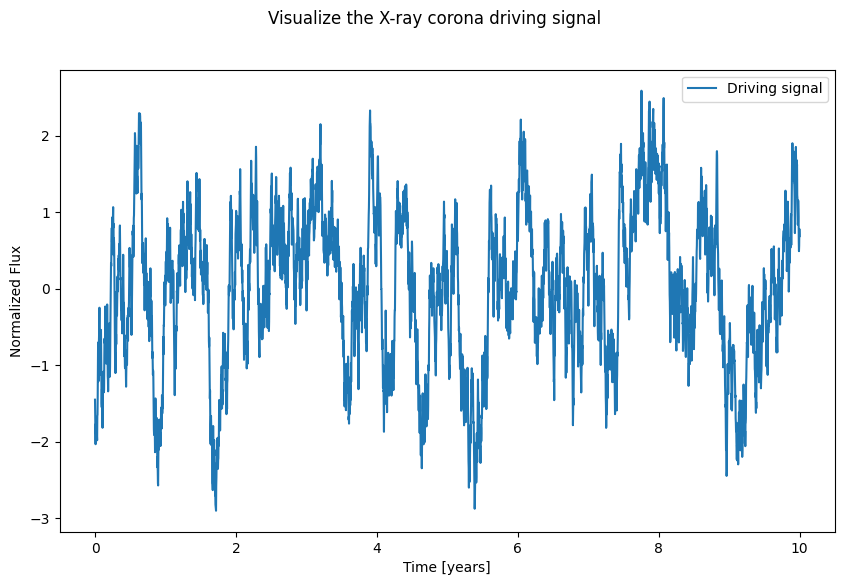

In [14]:
lsst_in_nm = [367.1, 482.7, 622.3, 754.6, 869.1, 971.2] # in nm
t_max = 10  # years, by default
delta_t = 1/365  # in years
SF_inf = 20
tau = 30/365  # in years
np.random.seed(3)

timestamps = np.linspace(0, t_max, int(t_max / delta_t) + 1)
DRW = util.generate_drw_signal(t_max, delta_t, SF_inf, tau, normalize=True)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(timestamps, DRW, label="Driving signal")

ax.set_xlabel("Time [years]")
ax.set_ylabel("Normalized Flux")
fig.suptitle("Visualize the X-ray corona driving signal")

ax.legend()
plt.show()



590650015220.0499
pixel_size_flux_array:  590650015220.0499
pixel_size_magnification_array:  833903381599.881
pixel_ratio:  0.7082955031155544
4096.0
0.7853981633974483


Text(0.5, 1.0, 'Moving a static u-band disk accross the microlensing map')

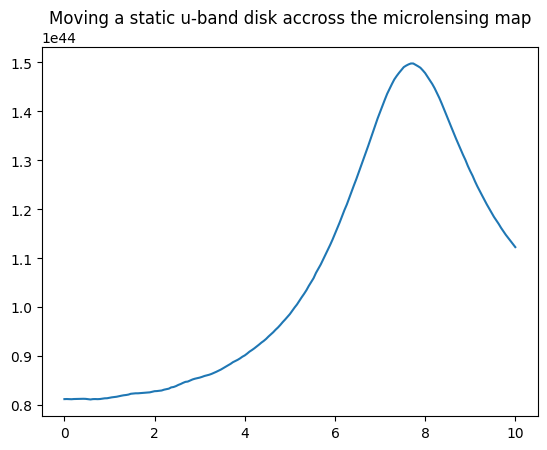

In [15]:
flux_projection_1 = my_disk.calculate_surface_intensity_map(lsst_in_nm[0])
seed = np.random.seed(0)
xpos,ypos=1000,1000

# flux_projection == 6 * 100 * num_pix * num_pix
# one trajectory per object - 
# compare the disk snapshot method with the transfer function method
# disk snapshot method encodes the actual transfer function
convolution_1 = MagMap.convolve_with_flux_projection(
    flux_projection_1, relative_orientation=0
)
LC_random_1 = convolution_1.pull_light_curve(500, 10,x_start_position=xpos,y_start_position=ypos,phi_travel_direction=45, random_seed=seed) # km/s , # 10 years, 
plt.plot(np.linspace(0,10,len(LC_random_1)), LC_random_1)
plt.title("Moving a static u-band disk accross the microlensing map")

590650015220.0499
pixel_size_flux_array:  590650015220.0499
pixel_size_magnification_array:  833903381599.881
pixel_ratio:  0.7082955031155544
4096.0
0.7853981633974483
590650015220.0499
pixel_size_flux_array:  590650015220.0499
pixel_size_magnification_array:  833903381599.881
pixel_ratio:  0.7082955031155544
4096.0
0.7853981633974483
590650015220.0499
pixel_size_flux_array:  590650015220.0499
pixel_size_magnification_array:  833903381599.881
pixel_ratio:  0.7082955031155544
4096.0
0.7853981633974483
590650015220.0499
pixel_size_flux_array:  590650015220.0499
pixel_size_magnification_array:  833903381599.881
pixel_ratio:  0.7082955031155544
4096.0
0.7853981633974483
590650015220.0499
pixel_size_flux_array:  590650015220.0499
pixel_size_magnification_array:  833903381599.881
pixel_ratio:  0.7082955031155544
4096.0
0.7853981633974483
590650015220.0499
pixel_size_flux_array:  590650015220.0499
pixel_size_magnification_array:  833903381599.881
pixel_ratio:  0.7082955031155544
4096.0
0.785

Text(0, 0.5, 'Magnification due to microlensing')

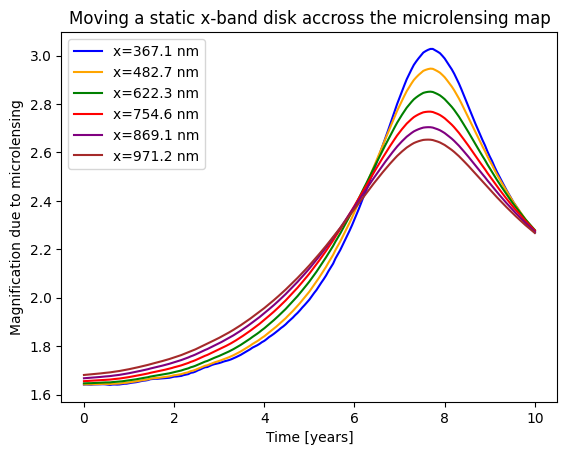

In [16]:
seed = np.random.seed(0)
xpos,ypos=1000,1000
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']
plt.figure()
for i in range(6):    
    flux_projection_x = my_disk.calculate_surface_intensity_map(lsst_in_nm[i])


    # flux_projection == 6 * 100 * num_pix * num_pix
    # one trajectory per object - 
    # compare the disk snapshot method with the transfer function method
    # disk snapshot method encodes the actual transfer function
    convolution_x = MagMap.convolve_with_flux_projection(
        flux_projection_x, relative_orientation=0
    )
    LC_random_x = convolution_x.pull_light_curve(500, 10,x_start_position=xpos,
                                                y_start_position=ypos,
                                                phi_travel_direction=45, 
                                                random_seed=seed) # km/s , # 10 years, 
    plt.plot(np.linspace(0,10,len(LC_random_x)), LC_random_x/np.sum(flux_projection_x.flux_array),color=colors[i],label=f'x={lsst_in_nm[i]} nm')

    plt.title("Moving a static x-band disk accross the microlensing map")
    plt.legend();
plt.xlabel("Time [years]")
plt.ylabel("Magnification due to microlensing")

Text(0, 0.5, 'x-band flux + magnification due to microlensing')

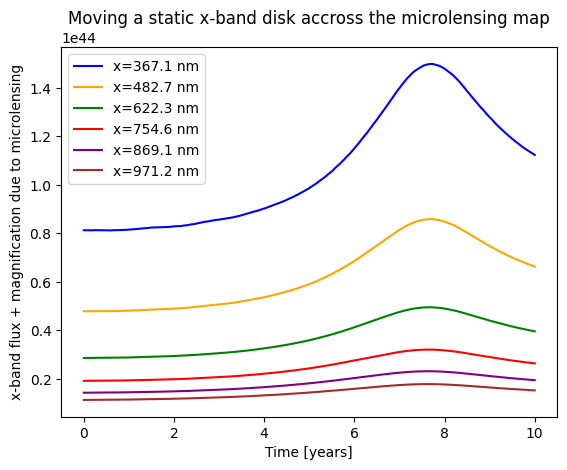

In [105]:
seed = np.random.seed(0)
xpos,ypos=1000,1000
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']
plt.figure()
for i in range(6):    
    flux_projection_x = my_disk.calculate_surface_intensity_map(lsst_in_nm[i])


    # flux_projection == 6 * 100 * num_pix * num_pix
    # one trajectory per object - 
    # compare the disk snapshot method with the transfer function method
    # disk snapshot method encodes the actual transfer function
    convolution_x = MagMap.convolve_with_flux_projection(
        flux_projection_x, relative_orientation=0
    )
    LC_random_x, x_pos, y_pos = convolution_x.pull_light_curve(500, 10,x_start_position=xpos,
                                                y_start_position=ypos,
                                                phi_travel_direction=45, 
                                                random_seed=seed, return_track_coords=True) # km/s , # 10 years, 
    plt.plot(np.linspace(0,10,len(LC_random_x)), LC_random_x,color=colors[i],label=f'x={lsst_in_nm[i]} nm')

    plt.title("Moving a static x-band disk accross the microlensing map")
    plt.legend();
plt.xlabel("Time [years]")
plt.ylabel("x-band flux + magnification due to microlensing")

In [19]:
import time

In [20]:
basic_tfs = {}
for i in range(6):
    basic_tfs[lsst_in_nm[i]] = my_disk.construct_accretion_disk_transfer_function(lsst_in_nm[i])


In [21]:
basic_tfs[lsst_in_nm[0]].shape

(1425,)

#### Decisions to make
1. How much resolution should we have in the accretion disk plane?
2. Currently, we're using a numerically integrated transfer function. Should we move to a parametric one? (gaussian, log-normal etc)
3. Create subsamples?
- For accretion disks that are much smaller than caustics -- can treat as point source
- For accretion disks in the 'goldilocks zone' -- will be affected in different colors when passing a caustic, size comparable to caustics, we should simulate the full accretion disk
- For accretion disks that are too large (~30% or bigger radius than the microlens), just apply macromagnification?

590650015220.0499
pixel_size_flux_array:  590650015220.0499
pixel_size_magnification_array:  833903381599.881
pixel_ratio:  0.7082955031155544
2189 7276
time taken = 1.3097078800201416
590650015220.0499
pixel_size_flux_array:  590650015220.0499
pixel_size_magnification_array:  833903381599.881
pixel_ratio:  0.7082955031155544
2189 7276
time taken = 1.2152318954467773
590650015220.0499
pixel_size_flux_array:  590650015220.0499
pixel_size_magnification_array:  833903381599.881
pixel_ratio:  0.7082955031155544
2189 7276
time taken = 1.070681095123291
590650015220.0499
pixel_size_flux_array:  590650015220.0499
pixel_size_magnification_array:  833903381599.881
pixel_ratio:  0.7082955031155544
2189 7276
time taken = 1.4295928478240967
590650015220.0499
pixel_size_flux_array:  590650015220.0499
pixel_size_magnification_array:  833903381599.881
pixel_ratio:  0.7082955031155544
2189 7276
time taken = 1.4565348625183105
590650015220.0499
pixel_size_flux_array:  590650015220.0499
pixel_size_magni

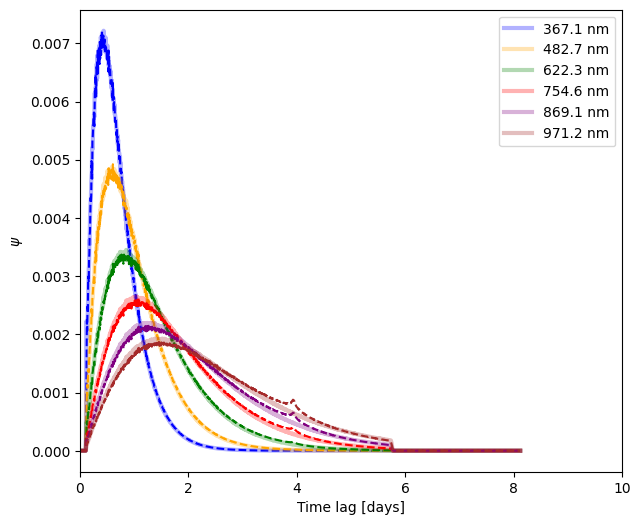

In [22]:
fig, ax = plt.subplots(1, figsize=(7,6))
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']
mag_to_color = dict(zip(lsst_in_nm,colors))
mag_to_tf = dict(zip(lsst_in_nm,colors))
xpos,ypos=2512 - (3012-2512), 7599 - (8099-7599)
r_g = util.calculate_gravitational_radius(10**8)*au.m
c = ac.c
for i in range(0,6):
    start_time = time.time()
    basic_transfer_function = basic_tfs[lsst_in_nm[i]]
    micro_tf = MagMap.calculate_microlensed_transfer_function(my_disk, lsst_in_nm[i],x_position=xpos,y_position=ypos)
    mag_to_tf[lsst_in_nm[i]]=micro_tf
    ax.plot(np.arange(len(basic_transfer_function))*r_g/c/(3600*24),basic_transfer_function, ls='-', lw=3,color=colors[i],alpha=0.3,label=f'{lsst_in_nm[i]} nm')
    ax.plot(np.arange(len(micro_tf))*r_g/c/(3600*24),micro_tf, ls='--',color=colors[i])
    end_time = time.time()
    print(f'time taken = {end_time-start_time}')
ax.set_xlim(0,10)
ax.set_xlabel("Time lag [days]")
ax.set_ylabel("$\psi$")
plt.legend();

In [23]:
timestamps*365

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 3.648e+03, 3.649e+03,
       3.650e+03])

Text(0.5, 1.0, 'Rest-frame AGN Variability')

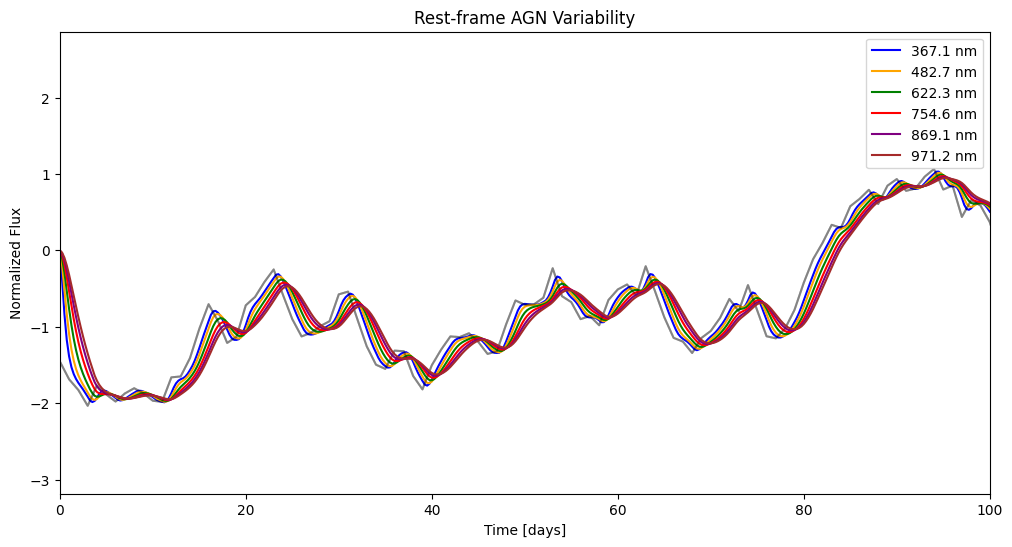

In [24]:
fig, ax = plt.subplots(1, figsize=(12,6))
for i in range(6):
    new_timestamps, signal_convolved = util.convolve_signal_with_transfer_function(
        smbh_mass_exp=smbh_mass_exp,
        driving_signal=DRW,
        transfer_function=mag_to_tf[lsst_in_nm[i]],
        initial_time_axis=timestamps*365,
        redshift_source=0,
        desired_cadence_in_days = 0.25
    )
    # signal_convolved=signal_convolved[:len(DRW)]
    # new_timestamps = new_timestamps[:len(DRW)]
    plt.plot(DRW,color='k',alpha=0.1)
    plt.xlim(0,100)
    plt.plot(new_timestamps,(signal_convolved-np.mean(signal_convolved))/np.std(signal_convolved),color=colors[i],label=f'{lsst_in_nm[i]} nm')
    plt.legend();
plt.xlabel("Time [days]")
plt.ylabel("Normalized Flux")
plt.title("Rest-frame AGN Variability")

In [25]:
timestamps.shape,new_timestamps.shape, 3651 * 1/0.25

((3651,), (14600,), 14604.0)

In [26]:
# time dilation -- are you passing observer frame timestamps or rest frame cadence 
# downsample to observer frame daily cadence 
#

In [25]:
timestamps.shape

(3651,)

In [69]:
from skimage.transform import rescale


In [91]:
x_pos.shape

(191,)

In [138]:
plt.figure()
mean_snapshot_dict = {}
num_days = 191
mean_plus_micro_snapshot_dict = {}

for i in range(6):
# i=0
    snapshots = my_disk.generate_snapshots(
        observer_frame_wavelength_in_nm=lsst_in_nm[i],
        time_stamps=timestamps[:num_days]*365,
        driving_signal=DRW,
        driving_signal_fractional_strength=0.5,
        corona_height=10,
        axis_offset_in_gravitational_radii=0,
        angle_offset_in_degrees=45,
    )
    mean_snapshot = []
    mean_plus_micro_snap = []
    pixel_ratio = my_disk.pixel_size / MagMap.pixel_size
    for j in range(num_days):
        sp = snapshots[j]
        flux_array_rescaled = rescale(sp, pixel_ratio)
        new_total_flux = np.sum(flux_array_rescaled)
        original_total_flux = np.sum(sp)

        # rescale values for flux conservation
        flux_array_rescaled *= original_total_flux / new_total_flux
        slice_len= flux_array_rescaled.shape[0]//2
        # xpos, ypos = np.random.randint(slice_len,MagMap.magnification_array.shape[0]),np.random.randint(slice_len,MagMap.magnification_array.shape[0])
        # xpos,ypos=1000,1000
        # xpos,ypos=np.random.randint(2000,6000),np.random.randint(2000,6000)
        # xpos,ypos=int(x_pos_interpolated[j]),int(y_pos_interpolated[j])

        xpos,ypos=int(x_pos[j]),int(y_pos[j] )       
        mag_map_slice = MagMap.magnification_array[xpos-slice_len: xpos+slice_len, ypos-slice_len:ypos+slice_len]

        mean_snapshot.append(sp.sum())
        mean_plus_micro_snap.append((flux_array_rescaled*mag_map_slice).sum())
    mean_snapshot_dict[lsst_in_nm[i]]=np.array(mean_snapshot)
    mean_plus_micro_snapshot_dict[lsst_in_nm[i]]=np.array(mean_plus_micro_snap)


<Figure size 640x480 with 0 Axes>

In [127]:
a = 500 * au.km/au.s
a.to(au.m/au.day)

<Quantity 4.32e+10 m / d>

In [129]:
MagMap.pixel_size*au.m

<Quantity 8.33903382e+11 m>

In [130]:
np.diff(x_pos_interpolated[:100]).mean()

0.03759371551319703

Text(0.5, 1.0, 'Integrated (sum) Flux of the Accretion Disk')

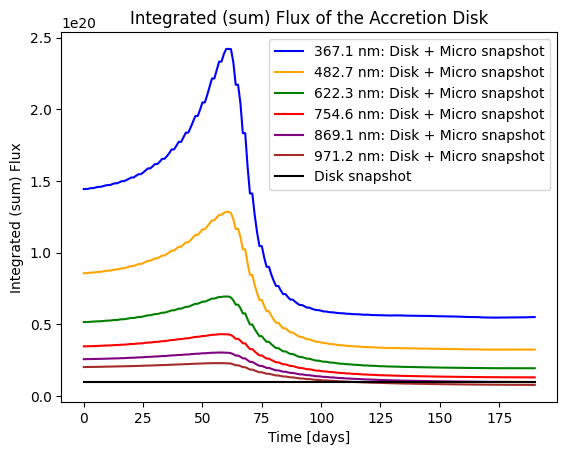

In [139]:
for i in range(6):

    plt.plot(timestamps[:num_days]*365,mean_plus_micro_snapshot_dict[lsst_in_nm[i]],color=colors[i],label=f'{lsst_in_nm[i]} nm: Disk + Micro snapshot')
plt.plot(timestamps[:num_days]*365,mean_snapshot_dict[lsst_in_nm[i]],color='k',label='Disk snapshot')
plt.legend()
plt.xlabel("Time [days]")
plt.ylabel("Integrated (sum) Flux");
plt.title("Integrated (sum) Flux of the Accretion Disk")

In [ ]:
# flux calibration check
# images include macromagnification: unlensed images should have original absolute magnitude, and lensed magnitude should be higher/lower
# pipeline ideally integrated in SLSim - finish up light curve processing here

# IMPORTANT: check where you are getting sf_inf and tau from -- is it empirical or are there scaling relations?
# how to get x-ray driving signal from colors
# tau + sf_inf is restframe or observer frame?

In [80]:
sp = snapshots[1]
pixel_ratio = my_disk.pixel_size / MagMap.pixel_size
print('pixel_ratio: ', pixel_ratio)
flux_array_rescaled = rescale(sp, pixel_ratio)
new_total_flux = np.sum(flux_array_rescaled)
original_total_flux = np.sum(sp)

# rescale values for flux conservation
flux_array_rescaled *= original_total_flux / new_total_flux
slice_len= flux_array_rescaled.shape[0]//2
# xpos, ypos = np.random.randint(slice_len,MagMap.magnification_array.shape[0]),np.random.randint(slice_len,MagMap.magnification_array.shape[0])
xpos,ypos=1000,1000
mag_map_slice = MagMap.magnification_array[xpos-slice_len: xpos+slice_len, ypos-slice_len:ypos+slice_len]


pixel_ratio:  0.7082955031155544


In [81]:
slice_len

177

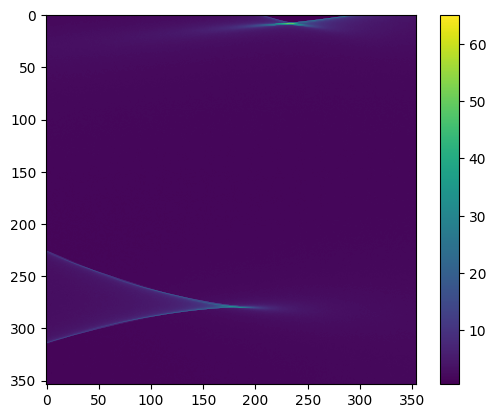

In [82]:
plt.imshow(mag_map_slice)
plt.colorbar()

Text(0.5, 1.0, 'Accretion Disk * \nMagnification Map')

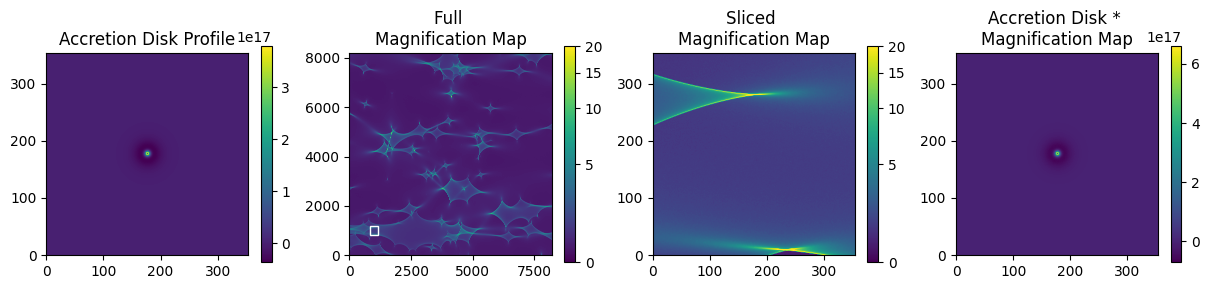

In [85]:
import matplotlib.patches as patches

fig,ax = plt.subplots(1,4,figsize=(15,4))
im=ax[0].imshow(flux_array_rescaled,origin='lower')
fig.colorbar(im,ax=ax[0],shrink=0.7)

ax[0].set_title("Accretion Disk Profile")
ax[1].set_title("Full \nMagnification Map")
norm = simple_norm(MagMap.magnification_array, stretch ='asinh', asinh_a=0.2, vmin=0, vmax=20)
im=ax[1].imshow(MagMap.magnification_array,cmap='viridis',norm=norm,origin='lower')
fig.colorbar(im,ax=ax[1],shrink=0.7)

rect = patches.Rectangle((xpos-slice_len, ypos-slice_len), slice_len*2, slice_len*2, linewidth=1, edgecolor='w', facecolor='none')  
ax[1].add_patch(rect) 
im=ax[2].imshow(mag_map_slice,cmap='viridis',norm=norm,origin='lower')
fig.colorbar(im,ax=ax[2],shrink=0.7)

ax[2].set_title("Sliced \nMagnification Map")
im = ax[3].imshow(flux_array_rescaled*mag_map_slice,origin='lower')
fig.colorbar(im,ax=ax[3],shrink=0.7)
ax[3].set_title("Accretion Disk * \nMagnification Map")

In [72]:
len(snapshots)

100

In [ ]:
for i in range(6):
    snapshots = my_disk.generate_snapshots(
        observer_frame_wavelength_in_nm=lsst_in_nm[i],
        time_stamps=np.arange(100),
        driving_signal=DRW,
        driving_signal_fractional_strength=0.5,
        corona_height=None,
        axis_offset_in_gravitational_radii=0,
        angle_offset_in_degrees=0,
    )
    mean_snapshot = []
    for snap in snapshots:
        mean_snapshot.append(np.mean(snapshots))
    plt.plot(np.arange(len(mean_snapshot)),(mean_snapshot-np.mean(mean_snapshot))/np.std(mean_snapshot),color=colors[i])

(1000, 1000)
22.82200793510171
3651 121.82200793510171


KeyboardInterrupt: 

In [ ]:
# try the method of generating snapshots and then convolving each snapshot with microlensing map?
# take microlensing map full of 1 -- make sure that your computed light curve maps to the tf convolved light curve
# Accretion disk is typically size of a caustic ~ 3 light days.
# run pycs on multiple bands -- see if we get unbiased results; if not we can do SBI or also model the transfer function
# how is the snapshot normalized?
# half light radius * 10 = size of cutout